In [153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import export_text
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import statsmodels.api as sm

In [154]:
df= pd.read_excel("mi_archivo.xlsx")

###1) procesamiento y definicion de variables

In [155]:
df_1=df.copy()

In [156]:
# supongamos que tu df se llama df
print(df_1.shape)         # filas, columnas
print(df_1.columns)       # nombres de columnas (verifica que existan las que usarás)
df_1.head()               # primera fila para inspección
df_1.info()               # tipos y nulos por columna

(14350, 52)
Index(['REGION', 'EDAD_SEL', 'SEXO_SEL', 'BHCH07_SEL',
       'NIVEL_EDUCATIVO_AGRUPADO', 'CONDICION_ACTIVIDAD', 'BHCH14_01_SEL',
       'CANT_MIEMBROS_HOGAR', 'CANT_PERSONASHASTA13', 'CANT_PERSONAS14A64',
       'CANT_PERSONAS65YMAS', 'CANT_DEMANDANTES_TOTAL',
       'CANT_NODEMANDANTES_TOTAL', 'CANT_DEMANDANTES_14A64',
       'CANT_DEMANDANTES_65YMAS', 'TIPO_HOGAR_DCTOTAL', 'TIPO_HOGAR_DCHASTA13',
       'TIPO_HOGAR_DC14YMAS', 'TIPO_HOGAR_DCAMBOS', 'TIPO_HOGAR_DCPOREDAD',
       'BHSL11_SEL', 'BHSL12_SEL', 'MAYORESACARGO_TOTAL',
       'MAYORES_CUIDADO_PAGO', 'T_DOMESTICO_OTROFAMILIAR',
       'T_DOMESTICO_SINPAGO', 'T_DOMESTICO_PAGO', 'T_DOMESTICO_MIEMBROS',
       'TP_GRUPO_DOMESTICO', 'TP_GRUPO_CUIDADO', 'TSS_GRUPO_TRABAJOOCUPACION',
       'TSS_GRANGRUPO_TNR', 'TSS_GRUPO_DOMESTICO', 'TSS_GRUPO_CUIDADO',
       'TSS_GRUPO_CUIDADOPERSONAL', 'TSS_GRUPO_TNROTROSHOGARES_VOLUNTARIAS',
       'TSS_GRUPO_VOLUNTARIAS', 'TSS_GRUPO_EDUCACION', 'TSS_GRUPO_CONVIVENCIA',
       'TS

In [157]:
actividades_ocio = [
    'TSS_ACT_DEPORTE',
    'TSS_ACT_USARCELULAR',
    'TSS_ACT_DORMIR',
    'TSS_ACT_REUNIRSEAMIGOS'
    # agregá o quitá columnas según tus nombres reales
]

# 3.2 Asegurarse de que sean numéricas (si hay strings, convertir)
df_1[actividades_ocio] = df_1[actividades_ocio].apply(pd.to_numeric, errors='coerce')

# 3.3 Sumar minutos y convertir a horas
df_1['TIEMPO_OCIO'] = df_1[actividades_ocio].sum(axis=1) / 60.0
# 3.3.1Eliminar  los valores mayores a 24 horas
df_1 = df_1[df_1['TIEMPO_OCIO'] <= 24]

# 3.4 Revisar resultados
df_1['TIEMPO_OCIO'].describe()

,TIEMPO_OCIO
count,14340.000000
mean,8.006333
std,4.133158
min,0.000000
25%,6.097720
50%,8.240964
75%,10.495177
max,24.000000


In [158]:
#  CREAR VARIABLE DE TIEMPO DE TRABAJO
actividades_trabajo = [
    'TSS_GRUPO_TRABAJOOCUPACION',
    'TSS_GRANGRUPO_TNR',
    'TSS_ACT_ESTUDIAR'
    ]# ajustá los nombres según tu base

df_1[actividades_trabajo] = df_1[actividades_trabajo].apply(pd.to_numeric, errors='coerce')
df_1['TIEMPO_TRABAJO'] = df_1[actividades_trabajo].sum(axis=1) / 60.0
# 3.4 Revisar resultados
df_1['TIEMPO_TRABAJO'].describe()


,TIEMPO_TRABAJO
count,14340.000000
mean,562.362295
std,1998.539595
min,0.000000
25%,3.911134
50%,7.500000
75%,10.997979
max,20138.866667


In [159]:
# Eliminar valores imposibles (ocio + trabajo > 24h)
df_1 = df_1[(df_1['TIEMPO_OCIO'] + df_1['TIEMPO_TRABAJO']) <= 24]

#  LIMPIEZA DE DATOS FALTANTES
df_1 = df_1.dropna(subset=['TIEMPO_OCIO', 'TIEMPO_TRABAJO'])
# 3.4 Revisar resultados
df_1['TIEMPO_TRABAJO'].describe()


,TIEMPO_TRABAJO
count,12886.000000
mean,6.771852
std,4.090847
min,0.000000
25%,3.500000
50%,6.802713
75%,9.878596
max,22.985795


In [160]:
df_1['TENENCIA_HIJOS_BIN'] = np.where(
    df_1['CANT_PERSONASHASTA13'].notna() & (df_1['CANT_PERSONASHASTA13'] > 0),
    1,
    np.where(df_1['CANT_PERSONASHASTA13'].notna(), 0, np.nan)
)

In [161]:
# Convertimos y creamos la dummy para estado civil
df_1['BHCH07_SEL'] = pd.to_numeric(df_1['BHCH07_SEL'], errors='coerce')
df_1['CASADO_UNIDO_BIN'] = df_1['BHCH07_SEL'].isin([1, 2]).astype(int)


In [162]:
df_1['NIVEL_EDUCATIVO_AGRUPADO'] = pd.to_numeric(df_1['NIVEL_EDUCATIVO_AGRUPADO'], errors='coerce')
df_1.loc[~df_1['NIVEL_EDUCATIVO_AGRUPADO'].isin([1, 2, 3, 4]), 'NIVEL_EDUCATIVO_AGRUPADO'] = np.nan

educ_dummies = pd.get_dummies(df_1['NIVEL_EDUCATIVO_AGRUPADO'], prefix='EDUC').astype(int)
educ_dummies.columns = educ_dummies.columns.str.replace('.0', '', regex=False)
df_1 = pd.concat([df_1, educ_dummies], axis=1)

In [163]:
# Edad: asegurar tipo numérico
df_1['EDAD_SEL'] = pd.to_numeric(df_1['EDAD_SEL'], errors='coerce')
df_1['EDAD_SEL2']= df_1['EDAD_SEL']**2

In [164]:
df_1['SEXO_BIN'] = df_1['SEXO_SEL'].apply(lambda x: 1 if x == 1 else 0)

In [165]:
educ_cols = ['EDUC_1', 'EDUC_2', 'EDUC_3', 'EDUC_4']
educ_dummies = pd.get_dummies(df_1['NIVEL_EDUCATIVO_AGRUPADO'], drop_first=True)

In [166]:
# Definir X y Y
X = df_1[['TENENCIA_HIJOS_BIN','CASADO_UNIDO_BIN','EDAD_SEL','SEXO_BIN','EDAD_SEL2','TIEMPO_TRABAJO']+ educ_cols]
Y = df_1['TIEMPO_OCIO']
X.insert(0, 'const', 1)
# Dividir los datos
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

###2 regresion lineal MCO (y variable numerica)

In [167]:
# Ajustar modelo
modelo_mco = sm.OLS(Y_train, X_train).fit()
print(modelo_mco.summary())

                            OLS Regression Results                            
Dep. Variable:            TIEMPO_OCIO   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     177.8
Date:                Thu, 13 Nov 2025   Prob (F-statistic):               0.00
Time:                        19:28:47   Log-Likelihood:                -26960.
No. Observations:               10308   AIC:                         5.394e+04
Df Residuals:                   10297   BIC:                         5.402e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 13.0269      0

In [168]:
# 2. Predecir sobre el test
y_pred_test = modelo_mco.predict(X_test)

# 3. Calcular RMSE
mse_test = mean_squared_error(Y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)

print(f"RMSE (Test): {rmse_test:.4f} horas")

RMSE (Test): 3.3101 horas


In [169]:
media_y = Y_test.mean()
print(f"Media TIEMPO_OCIO (Test): {media_y:.4f} horas")
print(f"RMSE relativo: {rmse_test / media_y:.3f} (RMSE / media)")

Media TIEMPO_OCIO (Test): 8.8683 horas
RMSE relativo: 0.373 (RMSE / media)


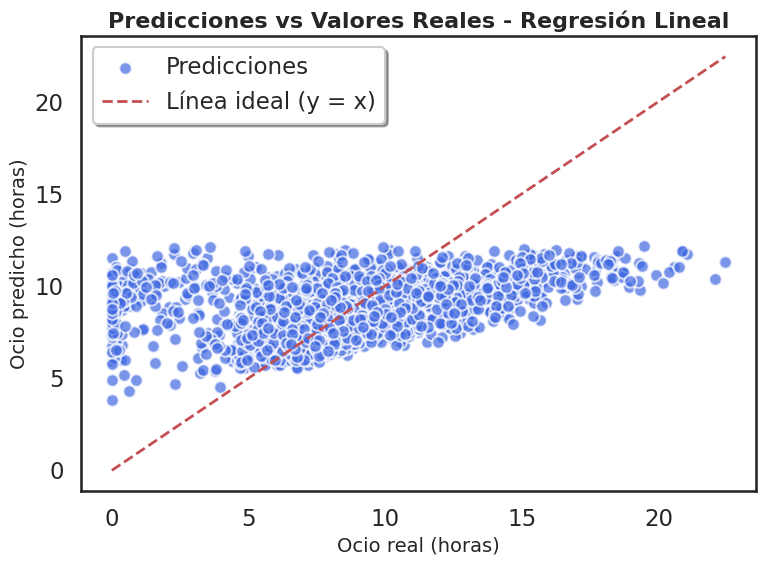

In [171]:
#opcional grafico
import matplotlib.pyplot as plt
import seaborn as sns

# Estilo limpio sin cuadrícula
sns.set(style="white", context="talk")  # cambia "whitegrid" por "white"

plt.figure(figsize=(8, 6))

# Dispersión con estilo profesional
plt.scatter(Y_test, y_pred_test, alpha=0.7, color='royalblue',
            edgecolor='white', s=80, label='Predicciones')

# Línea de referencia (predicción perfecta)
plt.plot(
    [Y_test.min(), Y_test.max()],
    [Y_test.min(), Y_test.max()],
    'r--', lw=2, label='Línea ideal (y = x)'
)

# Etiquetas y título
plt.xlabel('Ocio real (horas)', fontsize=14)
plt.ylabel('Ocio predicho (horas)', fontsize=14)
plt.title('Predicciones vs Valores Reales - Regresión Lineal',
          fontsize=16, weight='bold')

# Quitar cuadrícula (por si el estilo la agrega por defecto)
plt.grid(False)

# Leyenda estilizada
plt.legend(frameon=True, fancybox=True, shadow=True, loc='upper left')

# Ajuste de márgenes
plt.tight_layout()

# Mostrar
plt.show()


###3 Graficos/ analisis descriptivo

In [172]:
#copia
df_2=df_1.copy()

In [173]:
# Calcular percentil 25 en el conjunto de entrenamiento
p25 = Y_train.quantile(0.25)
print(f"Umbral P25 de tiempo de ocio: {p25:.2f} horas")

# Crear la variable categórica: 1 si ocio < P25, 0 en otro caso
df_2['OCIO_BAJO'] = np.where(df_2['TIEMPO_OCIO'] < p25, 1, 0)


Umbral P25 de tiempo de ocio: 6.79 horas


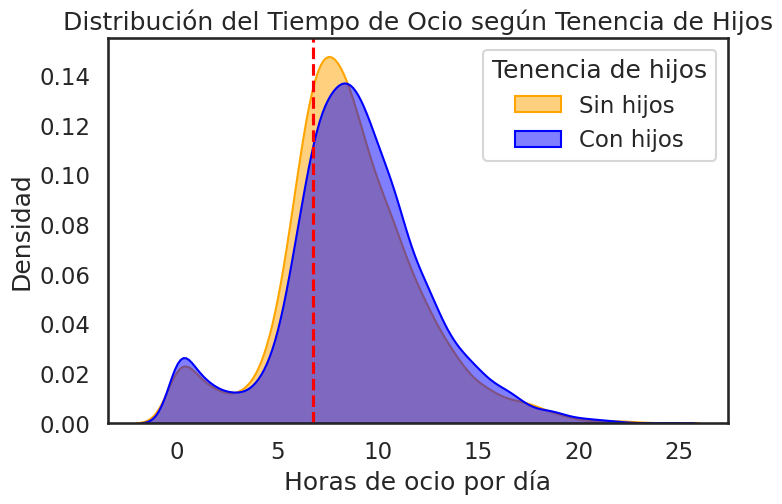

In [174]:
plt.figure(figsize=(8, 5))
sns.kdeplot(
    data=df_2,
    x='TIEMPO_OCIO',
    hue='TENENCIA_HIJOS_BIN',
    fill=True,
    common_norm=False,
    palette=['blue', 'orange'],
    alpha=0.5
)

# Línea vertical del umbral P25
plt.axvline(p25, color='red', linestyle='--', label=f'P25 = {p25:.2f}h')

plt.title('Distribución del Tiempo de Ocio según Tenencia de Hijos')
plt.xlabel('Horas de ocio por día')
plt.ylabel('Densidad')
plt.legend(title='Tenencia de hijos', labels=['Sin hijos', 'Con hijos'])
plt.show()

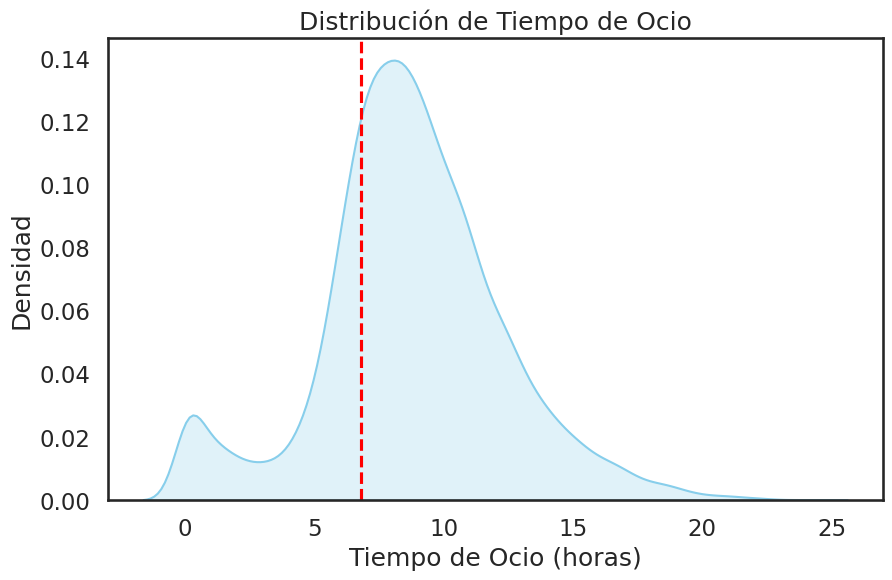

In [197]:
from matplotlib.lines import lineStyles
# Distribución de tiempo de ocio
plt.figure(figsize=(10, 6))
sns.kdeplot(df_1['TIEMPO_OCIO'], fill=True, color='skyblue')
plt.title('Distribución de Tiempo de Ocio')
plt.xlabel('Tiempo de Ocio (horas)')
plt.ylabel('Densidad')
# Línea vertical del umbral P25
plt.axvline(p25, color='red', linestyle='--', label=f'P25 = {p25:.2f}h')

# Quitar la cuadrícula
plt.grid(False)

plt.show()


###4 modelos de clasificacion (Y categorica)

# logit

In [175]:
#copia
df_3=df_1.copy()

In [176]:
X_full = df_3[['TENENCIA_HIJOS_BIN', 'CASADO_UNIDO_BIN', 'SEXO_BIN', 'EDAD_SEL', 'EDAD_SEL'] + educ_cols].copy()
# Nota: quitá duplicados en la lista anterior si EDAD_SEL aparece dos veces.

# Para evitar errores: si alguna columna está repetida o faltante, filtrala:
X_full = X_full.loc[:,~X_full.columns.duplicated()]  # quita duplicados
X_full = X_full.dropna(axis=0, how='any')  # por simplicidad, quitamos filas con NA en X_full

# Y temporal: TIEMPO_OCIO (necesitamos dividir train/test antes de crear OCIO_BAJO)
Y_tiempo = df_3.loc[X_full.index, 'TIEMPO_OCIO']

In [177]:
# 2) TRAIN / TEST split (usamos TIEMPO_OCIO para calcular P25 en train)
X_train, X_test, Ytime_train, Ytime_test, idx_train, idx_test = train_test_split(
    X_full, Y_tiempo, X_full.index, test_size=0.2, random_state=42
)


In [178]:

# Calcular P25 en TRAIN
p25 = np.percentile(Ytime_train, 25)
print("Umbral P25 (horas) calculado en TRAIN:", round(p25, 3))

# Crear OCIO_BAJO en el df_1 usando el umbral obtenido en TRAIN
df_3['OCIO_BAJO'] = (df_3['TIEMPO_OCIO'] < p25).astype(int)

# Ahora definimos Y (binaria), alineada con X_full
Y_full = df_3.loc[X_full.index, 'OCIO_BAJO']
Y_train = Y_full.loc[idx_train]
Y_test = Y_full.loc[idx_test]

Umbral P25 (horas) calculado en TRAIN: 6.791


In [179]:
# Añadir constante para statsmodels
X_train_sm = sm.add_constant(X_train)
logit_model = sm.Logit(Y_train, X_train_sm).fit(disp=False)  # disp=False para no imprimir el output extenso

print("\n--- Resumen Logit (extracto) ---")
print(logit_model.summary2().tables[1])  # tabla de coeficientes (coef, std err, z, p>|z|)

# Direcciones de los coeficientes de interés (sólo signo)
for var in ['TENENCIA_HIJOS_BIN', 'CASADO_UNIDO_BIN']:
    if var in logit_model.params.index:
        coef = logit_model.params[var]
        sign = 'positivo' if coef > 0 else 'negativo' if coef < 0 else 'cero'
        print(f"Coeficiente {var}: {coef:.4f} ({sign})")
    else:
        print(f"Variable {var} no está en el modelo.")


--- Resumen Logit (extracto) ---
                       Coef.  Std.Err.         z     P>|z|    [0.025    0.975]
const              -1.676369  0.460976 -3.636568  0.000276 -2.579865 -0.772874
TENENCIA_HIJOS_BIN  0.238811  0.055037  4.339066  0.000014  0.130940  0.346683
CASADO_UNIDO_BIN    0.155609  0.048495  3.208798  0.001333  0.060562  0.250657
SEXO_BIN           -0.197088  0.046474 -4.240782  0.000022 -0.288176 -0.106000
EDAD_SEL            0.003219  0.001377  2.336866  0.019446  0.000519  0.005919
EDUC_1              0.255413  0.463721  0.550790  0.581778 -0.653464  1.164289
EDUC_2              0.290134  0.455956  0.636320  0.524568 -0.603524  1.183793
EDUC_3              0.386308  0.456376  0.846468  0.397292 -0.508173  1.280789
EDUC_4              0.519334  0.455815  1.139354  0.254556 -0.374046  1.412714
Coeficiente TENENCIA_HIJOS_BIN: 0.2388 (positivo)
Coeficiente CASADO_UNIDO_BIN: 0.1556 (positivo)


In [180]:
# Preparamos X_test con constante
X_test_sm = sm.add_constant(X_test)
y_pred_prob_logit = logit_model.predict(X_test_sm)  # probabilidad de OCIO_BAJO
y_pred_logit = (y_pred_prob_logit >= 0.5).astype(int)

acc_logit = accuracy_score(Y_test, y_pred_logit)
error_logit = 1 - acc_logit
print(f"\nLogit - Accuracy: {acc_logit:.4f} | Error rate: {error_logit:.4f}")


Logit - Accuracy: 0.7676 | Error rate: 0.2324


# cart

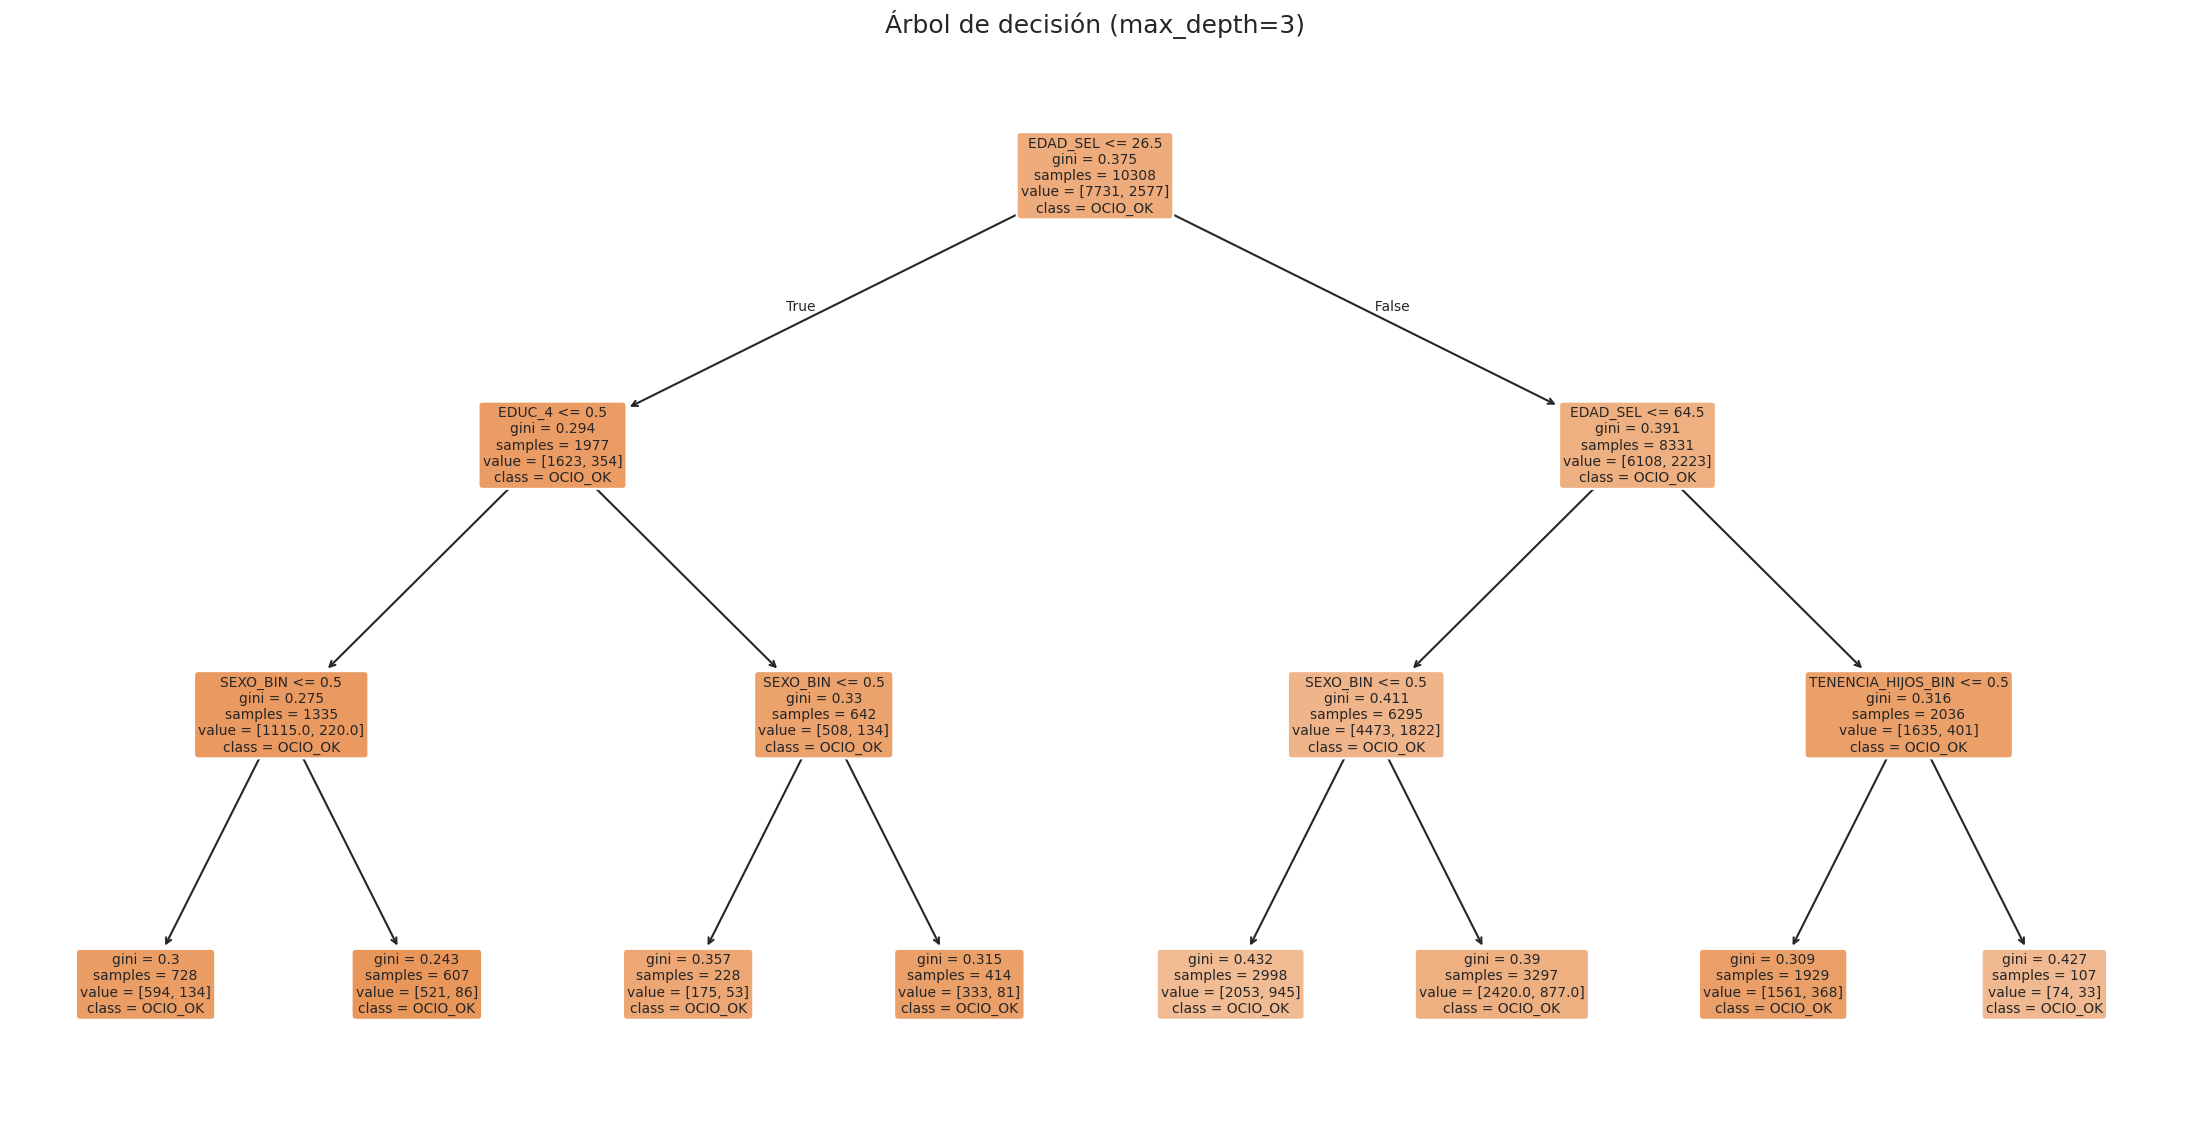


--- Reglas del árbol (texto) ---

|--- EDAD_SEL <= 26.50
|   |--- EDUC_4 <= 0.50
|   |   |--- SEXO_BIN <= 0.50
|   |   |   |--- class: 0
|   |   |--- SEXO_BIN >  0.50
|   |   |   |--- class: 0
|   |--- EDUC_4 >  0.50
|   |   |--- SEXO_BIN <= 0.50
|   |   |   |--- class: 0
|   |   |--- SEXO_BIN >  0.50
|   |   |   |--- class: 0
|--- EDAD_SEL >  26.50
|   |--- EDAD_SEL <= 64.50
|   |   |--- SEXO_BIN <= 0.50
|   |   |   |--- class: 0
|   |   |--- SEXO_BIN >  0.50
|   |   |   |--- class: 0
|   |--- EDAD_SEL >  64.50
|   |   |--- TENENCIA_HIJOS_BIN <= 0.50
|   |   |   |--- class: 0
|   |   |--- TENENCIA_HIJOS_BIN >  0.50
|   |   |   |--- class: 0



In [181]:
#  AJUSTE DEL CART (DecisionTreeClassifier)
cart = DecisionTreeClassifier(max_depth=3, random_state=42)
cart.fit(X_train, Y_train)

# Visualizar árbol
plt.figure(figsize=(28,14))
plot_tree(cart, feature_names=X_train.columns, class_names=['OCIO_OK','OCIO_BAJO'],
           filled=True, rounded=True, fontsize=10)
plt.title('Árbol de decisión (max_depth=3)')
plt.savefig("arbol_ocio.png", dpi=300, bbox_inches='tight')
plt.show()
# Mostrar reglas textuales del árbol (completo, hasta profundidad especificada)
rules_text = export_text(cart, feature_names=list(X_train.columns))
print("\n--- Reglas del árbol (texto) ---\n")
print(rules_text)


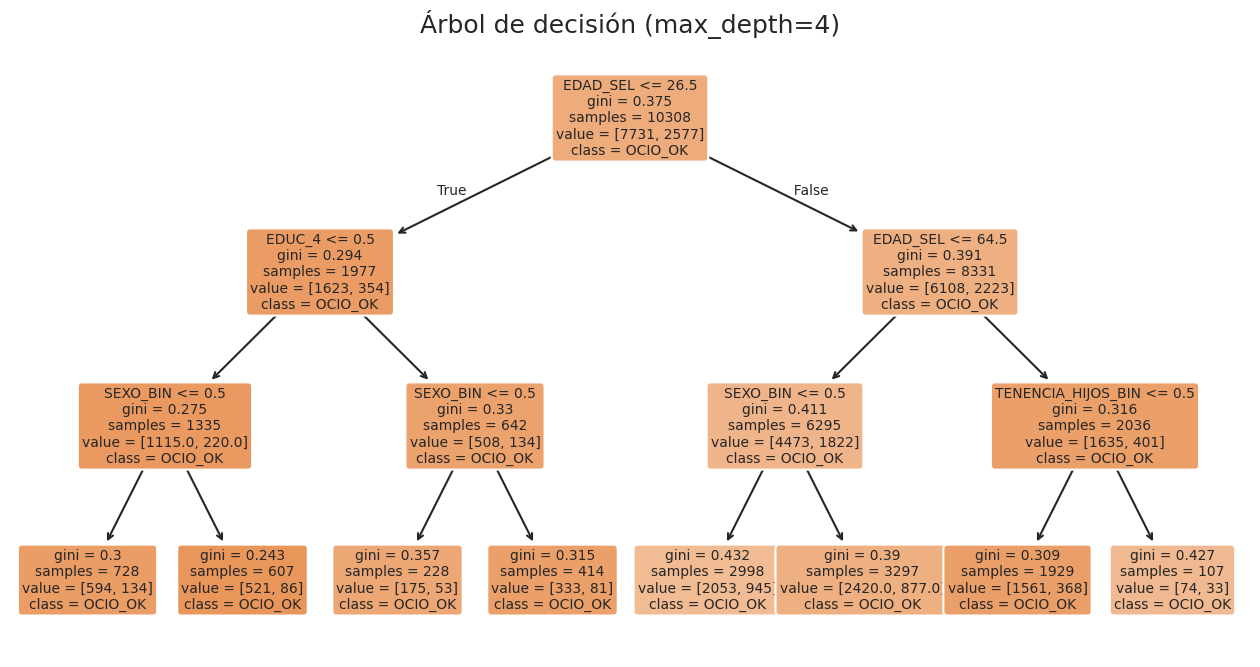


--- Reglas del árbol (texto) ---

|--- EDAD_SEL <= 26.50
|   |--- EDUC_4 <= 0.50
|   |   |--- SEXO_BIN <= 0.50
|   |   |   |--- class: 0
|   |   |--- SEXO_BIN >  0.50
|   |   |   |--- class: 0
|   |--- EDUC_4 >  0.50
|   |   |--- SEXO_BIN <= 0.50
|   |   |   |--- class: 0
|   |   |--- SEXO_BIN >  0.50
|   |   |   |--- class: 0
|--- EDAD_SEL >  26.50
|   |--- EDAD_SEL <= 64.50
|   |   |--- SEXO_BIN <= 0.50
|   |   |   |--- class: 0
|   |   |--- SEXO_BIN >  0.50
|   |   |   |--- class: 0
|   |--- EDAD_SEL >  64.50
|   |   |--- TENENCIA_HIJOS_BIN <= 0.50
|   |   |   |--- class: 0
|   |   |--- TENENCIA_HIJOS_BIN >  0.50
|   |   |   |--- class: 0



In [182]:
# opcional
cart = DecisionTreeClassifier(max_depth=3, random_state=42)
cart.fit(X_train, Y_train)

# Visualizar árbol
plt.figure(figsize=(16,8))
plot_tree(cart, feature_names=X_train.columns, class_names=['OCIO_OK','OCIO_BAJO'], filled=True, rounded=True, fontsize=10)
plt.title('Árbol de decisión (max_depth=4)')
plt.show()

# Mostrar reglas textuales del árbol (completo, hasta profundidad especificada)
rules_text = export_text(cart, feature_names=list(X_train.columns))
print("\n--- Reglas del árbol (texto) ---\n")
print(rules_text)


In [183]:
# identificación de la hoja con mayor probabilidad de clase 1
tree = cart.tree_
# Cada leaf node has value: tree.value[node] -> array [[n_class0, n_class1]]
leaf_indices = np.where(tree.children_left == -1)[0]
leaf_probs = []
for leaf in leaf_indices:
    counts = tree.value[leaf][0]  # [n0, n1]
    prob1 = counts[1] / counts.sum() if counts.sum() > 0 else 0
    leaf_probs.append((leaf, prob1, counts.sum()))


In [184]:
# Seleccionar la hoja con mayor probabilidad de clase 1
leaf_best = max(leaf_probs, key=lambda x: (x[1], x[2]))  # prioriza prob, desempata por tamaño
leaf_id_best = leaf_best[0]
leaf_best_prob = leaf_best[1]
leaf_best_n = leaf_best[2]
print(f"\nHoja con mayor probabilidad de OCIO_BAJO: node {leaf_id_best} | prob={leaf_best_prob:.3f} | n={leaf_best_n}")



Hoja con mayor probabilidad de OCIO_BAJO: node 10 | prob=0.315 | n=1.0


In [185]:
def get_rule_for_node(tree, feature_names, target_node_id):
    """
    Devuelve la regla (camino desde la raíz) que lleva al nodo indicado.
    """
    left = tree.children_left
    right = tree.children_right
    threshold = tree.threshold
    features = [feature_names[i] if i != -2 else "undefined!" for i in tree.feature]

    def recurse(current_node, target_node, conditions):
        if current_node == target_node:
            return True, conditions
        if left[current_node] != -1:
            cond = f"({features[current_node]} <= {threshold[current_node]:.4f})"
            found, c = recurse(left[current_node], target_node, conditions + [cond])
            if found:
                return True, c
        if right[current_node] != -1:
            cond = f"({features[current_node]} > {threshold[current_node]:.4f})"
            found, c = recurse(right[current_node], target_node, conditions + [cond])
            if found:
                return True, c
        return False, None

    found, conds = recurse(0, target_node_id, [])
    if not found or conds is None:
        return "⚠️ No se encontró la regla para este nodo."
    return " AND ".join(conds)

In [186]:
rule_best = get_rule_for_node(tree, list(X_train.columns), leaf_id_best)
print("\nRegla (camino) hacia la hoja con mayor probabilidad de OCIO_BAJO:")
print(rule_best)


Regla (camino) hacia la hoja con mayor probabilidad de OCIO_BAJO:
(EDAD_SEL > 26.5000) AND (EDAD_SEL <= 64.5000) AND (SEXO_BIN <= 0.5000)


# comparamos los modelos

In [187]:
# Para el modelo LOGIT
acc_logit = accuracy_score(Y_test, y_pred_logit)
error_logit = 1 - acc_logit
print(f"Logit - Accuracy: {acc_logit:.4f} | Tasa de error: {error_logit:.4f}")

# Para el modelo CART
y_pred_cart = cart.predict(X_test)
acc_cart = accuracy_score(Y_test, y_pred_cart)
error_cart = 1 - acc_cart
print(f"CART - Accuracy: {acc_cart:.4f} | Tasa de error: {error_cart:.4f}")

# Comparación final
print("\n--- Comparación ---")
print(f"Logit: Accuracy = {acc_logit:.3f} | Error = {error_logit:.3f}")
print(f"CART:  Accuracy = {acc_cart:.3f} | Error = {error_cart:.3f}")

Logit - Accuracy: 0.7676 | Tasa de error: 0.2324
CART - Accuracy: 0.7676 | Tasa de error: 0.2324

--- Comparación ---
Logit: Accuracy = 0.768 | Error = 0.232
CART:  Accuracy = 0.768 | Error = 0.232


In [188]:
print("\nSugerencia de interpretación:")
print("- Si coef(TENENCIA_HIJOS_BIN) > 0 (logit): ser padre/madre aumenta la probabilidad de OCIO_BAJO.")
print("- Si coef(CASADO_UNIDO_BIN) > 0 (logit): estar casado/unido aumenta la probabilidad de OCIO_BAJO.")
print("- En el CART, revisar la regla impresa arriba para ver la combinación de condiciones que más asocian con OCIO_BAJO.")


Sugerencia de interpretación:
- Si coef(TENENCIA_HIJOS_BIN) > 0 (logit): ser padre/madre aumenta la probabilidad de OCIO_BAJO.
- Si coef(CASADO_UNIDO_BIN) > 0 (logit): estar casado/unido aumenta la probabilidad de OCIO_BAJO.
- En el CART, revisar la regla impresa arriba para ver la combinación de condiciones que más asocian con OCIO_BAJO.
